In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from   pandas.plotting import autocorrelation_plot
from   pmdarima.arima import auto_arima
from   pylab import rcParams
import scipy.stats
import seaborn as sns
import time
import statsmodels.api as sm

pd.plotting.register_matplotlib_converters()          

## Predicting a target series using univariate time series analysis & supervised learning (approach 1 and 2)

In [9]:
df = pd.read_csv('Downloads/code-challenges-master/challenge_data.csv')

In [10]:
df.head()

,timestamp,target,var_1,var_2,var_3,var_4,var_5,var_6
0,1518825600,1.868908,-0.882872,-1.155362,43,16,1381.507157,486.810500
1,1518829200,1.668685,-0.874538,-1.155095,57,10,1386.481610,21.222100
2,1518832800,0.663499,-0.873016,-1.154836,49,11,334.726437,85.505730
3,1518836400,0.737500,-0.889525,-1.154571,36,25,559.711136,3264.009017
4,1518840000,1.442681,-0.904973,-1.154303,55,35,124.505173,2655.059472


### Convert epoch timestamp to [DatetimeIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html)

In [11]:
df = df.set_index(pd.to_datetime(df['timestamp'],unit='s'))
df = df.drop('timestamp', axis=1)
df.sort_index(inplace=True)

df.head()

,target,var_1,var_2,var_3,var_4,var_5,var_6
timestamp,,,,,,,
2018-02-17 00:00:00,1.868908,-0.882872,-1.155362,43,16,1381.507157,486.810500
2018-02-17 01:00:00,1.668685,-0.874538,-1.155095,57,10,1386.481610,21.222100
2018-02-17 02:00:00,0.663499,-0.873016,-1.154836,49,11,334.726437,85.505730
2018-02-17 03:00:00,0.737500,-0.889525,-1.154571,36,25,559.711136,3264.009017
2018-02-17 04:00:00,1.442681,-0.904973,-1.154303,55,35,124.505173,2655.059472


### Visualize all variables through time 

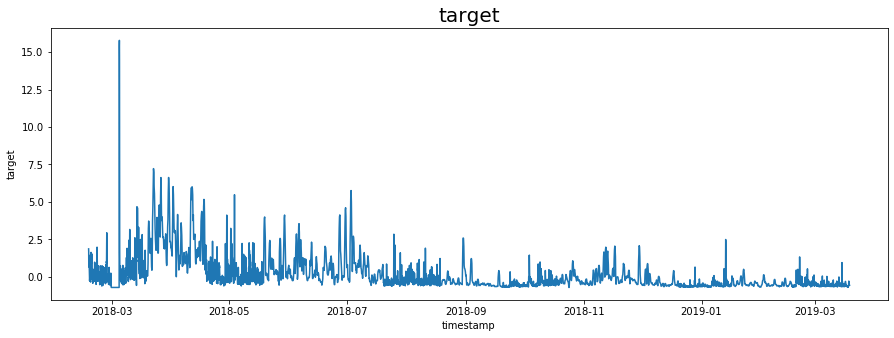

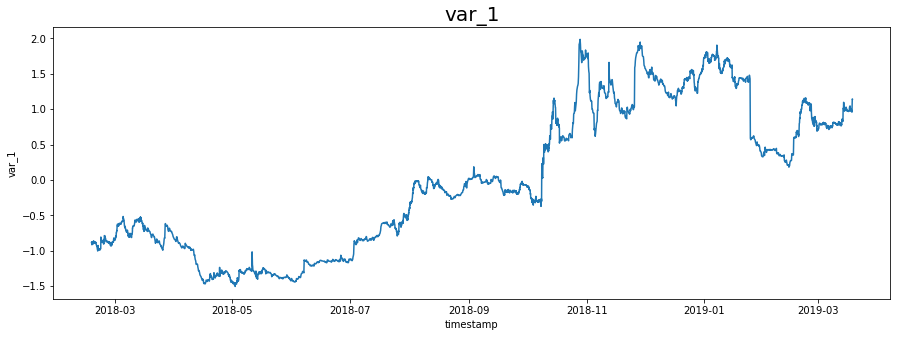

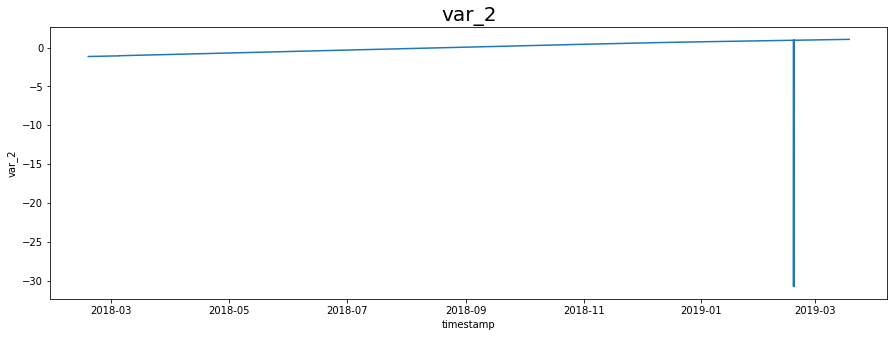

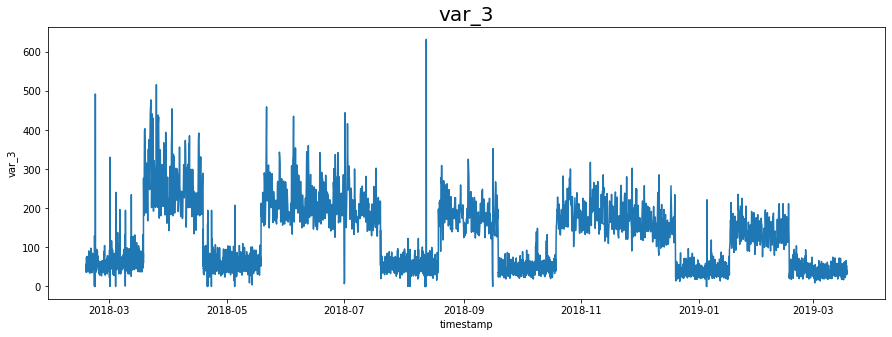

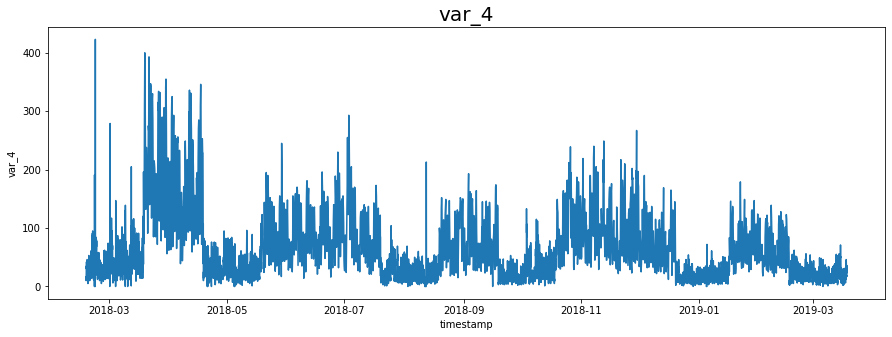

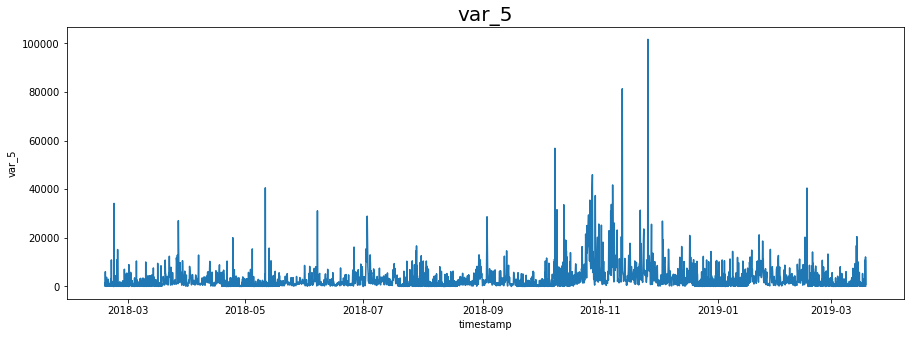

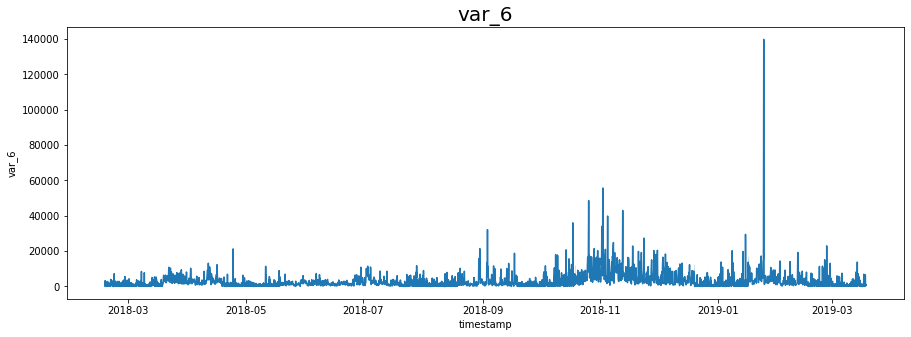

In [52]:
for i in df.columns:
    ax = plt.subplots(figsize=(15, 5))
    ax = sns.lineplot(data=df, x=df.index, y=i).set_title(i, fontsize=20)
    plt.show()
      

### To use ARIMA to understand Target variable we need complete observations. Coarce data into a 6 hour timeframe and this is solved. 

Looks as if we miss the peak of target > 15 in March 2018, but the rest of the peaks remain similar to the original series. 

In [44]:
y = df['target'].resample('6H').mean()

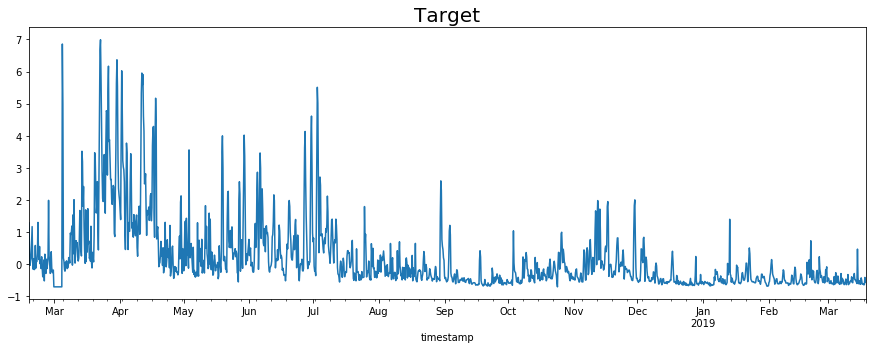

1580


In [53]:
y.plot(figsize=(15, 5)).set_title('Target', fontsize=20)
plt.show()

print(len(y))

### Decomposition of target series, to further understand it: Trend & Seasonal behaviour

The seasonal behaviour has a cicle shorter than a week, residuals look to high. 

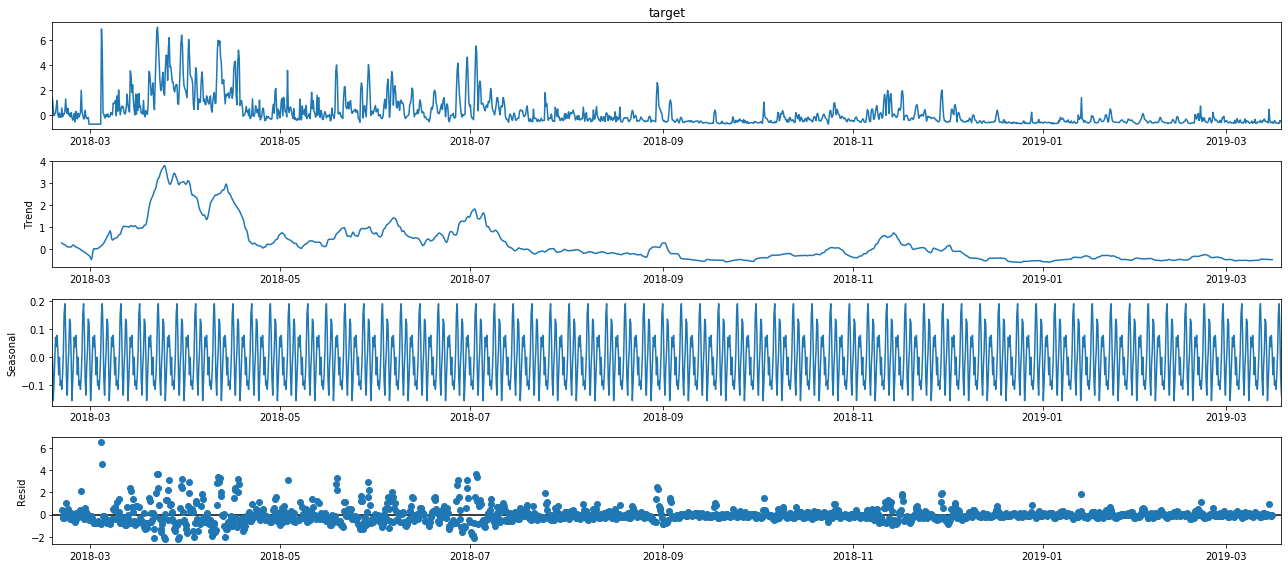

In [56]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
ax = decomposition.plot()
plt.show()

### Autocorrelation plots show the amount of lags that each observation is related to. 
It looks like each value impacts the value positively up to 100 days. [More info on Autocorrelation plots](https://www.dummies.com/programming/big-data/data-science/autocorrelation-plots-graphical-technique-for-statistical-data/#:~:text=An%20autocorrelation%20plot%20shows%20the,known%20as%20a%20time%20series.&text=(The%20prefix%20auto%20means%20%E2%80%9Cself,acf)%20on%20the%20vertical%20axis.) 

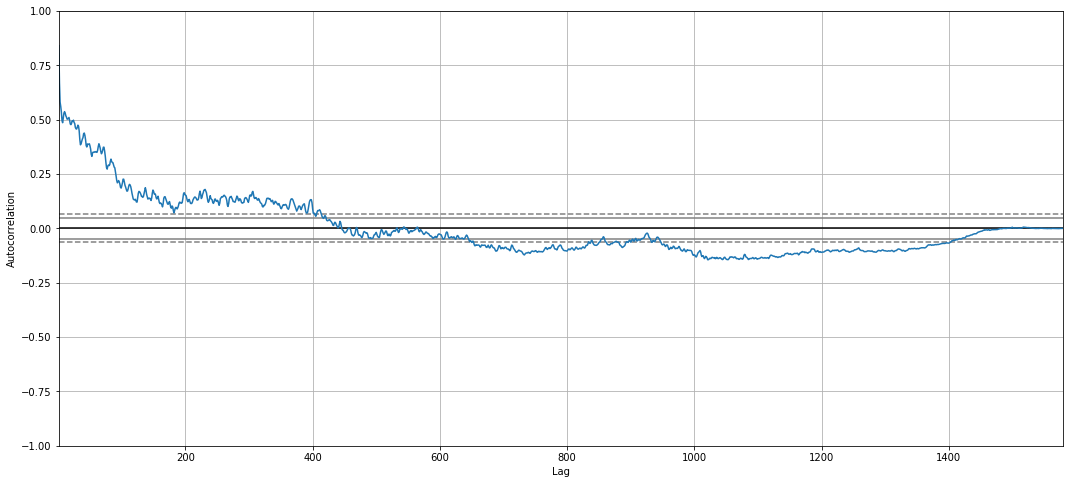

In [66]:
autocorrelation_plot(y.resample('6H').mean())
plt.show()

In [24]:
y.index[400] - y.index[0] 

Timedelta('100 days 00:00:00')

### Approach 1: use same target series to predict itself, with an ARIMA model, using an [auto_arima function](https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html)

In [76]:
stepwise_model = auto_arima(y, start_p=1, start_q=1,
                           max_p=5, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4169.422, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3649.524, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4170.949, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3498.844, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.82 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.37 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3502.594, Time=0.78 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3381.309, Time=1.60 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3510.245, Time=0.79 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=17.16 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=6.25 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=3324.649, Time=3.35 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=3449.

### Predict with ARIMA(5,1,0)(2,1,0)[12]
Although p=5 seems a high value for a parameter, probably an overfitted model, we'll use to predict the series using the first 80% of it to predict the lastet 20%. 

In [95]:
train = y.loc['2018-02-17 00:00:00':'2018-12-30 00:00:00']
test  = y.loc['2018-12-30 00:00:00':]

stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=len(test))

In [97]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

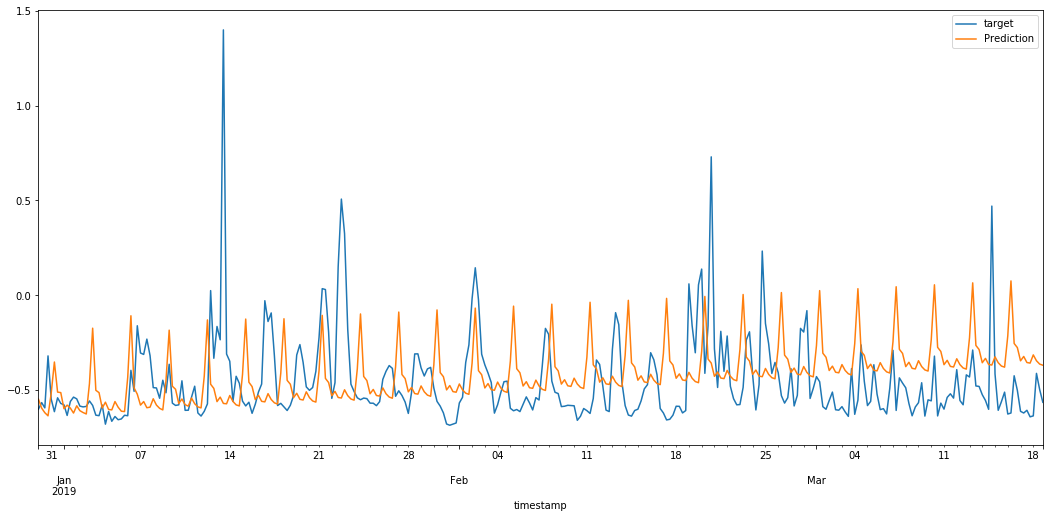

In [98]:
pd.concat([test,future_forecast],axis=1).plot()
plt.show()

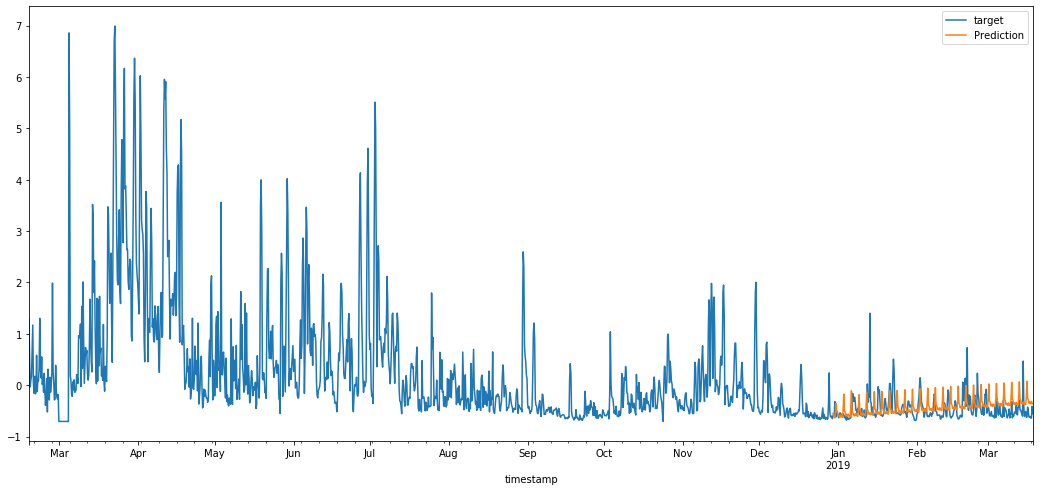

In [99]:
pd.concat([y,future_forecast],axis=1).plot()
plt.show()

### Approach 2: use supervised learning, use var_3 and var_4 to predict target

In [43]:
for i in df.columns[1:]:
    print(i)
    if  scipy.stats.pearsonr(df['target'] , df[i])[1] < 0.05: 
        print('P Corr ', scipy.stats.pearsonr(df['target'] , df[i])[0])
    if scipy.stats.spearmanr(df['target'] , df[i])[1] < 0.05: 
        print('S Corr ', scipy.stats.spearmanr(df['target'] , df[i])[0])
    

var_1
P Corr  -0.3758881209848473
S Corr  -0.5306896442783888
var_2
P Corr  -0.2912330623309993
S Corr  -0.5429892224414965
var_3
P Corr  0.4233185181306624
S Corr  0.4569424197983921
var_4
P Corr  0.44777505115860694
S Corr  0.4079812123968603
var_5
P Corr  0.11714948292502878
S Corr  0.1886553974420603
var_6
P Corr  0.11247390316458834
S Corr  0.24568152465181925
